<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Background_dependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- 1️⃣ Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- 2️⃣ Clone GitHub repo (contains src/NPI.py) ---
!rm -rf /content/BrainStim_ANN_fMRI_HCP
!git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git

# --- 3️⃣ Define paths ---
import os, sys, gc
repo_dir    = "/content/BrainStim_ANN_fMRI_HCP"
data_dir    = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"
preproc_dir = os.path.join(data_dir, "preprocessed_subjects")
models_dir  = os.path.join(preproc_dir, "trained_models_MLP")
ects_dir    = os.path.join(preproc_dir, "ECts_MLP")
os.makedirs(ects_dir, exist_ok=True)

if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# --- 4️⃣ Imports ---
import numpy as np
from scipy import stats
import torch
import torch.serialization
from src import NPI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Repo loaded from:", repo_dir)
print("Using device:", device)

# --- 5️⃣ Choose which subjects to process ---
# either specify manually:
#subjects = ["id_100206"]
# or automatically detect all
subjects = sorted({fn.split("_signals.npy")[0]
                   for fn in os.listdir(preproc_dir)
                   if fn.endswith("_signals.npy")})

Mounted at /content/drive
Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 155 (delta 43), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (155/155), 23.90 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (43/43), done.
✅ Repo loaded from: /content/BrainStim_ANN_fMRI_HCP
Using device: cpu


In [2]:
# ============================================
# 📦 Load EC_t and X for all subjects
# ============================================

ECts = {}   # will hold EC_t arrays per subject
Xs   = {}   # will hold input X arrays per subject

for sid in subjects:
    ECt_path = os.path.join(ects_dir, f"{sid}_ECt.npy")
    X_path   = os.path.join(preproc_dir, f"{sid}_inputs.npy")

    if not os.path.exists(ECt_path):
        print(f"⚠️ Skipping {sid}: EC_t file not found.")
        continue
    if not os.path.exists(X_path):
        print(f"⚠️ Skipping {sid}: inputs file not found.")
        continue

    ECts[sid] = np.load(ECt_path)
    Xs[sid]   = np.load(X_path)

    print(f"✅ Loaded {sid}: EC_t {ECts[sid].shape}, X {Xs[sid].shape}")

print(f"\n🎯 Loaded {len(ECts)} subjects successfully.")


✅ Loaded id_100206: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100307: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_100408: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101006: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101107: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101309: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_101915: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102008: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102109: EC_t (500, 450, 450), X (4677, 1350)
✅ Loaded id_102311: EC_t (500, 450, 450), X (4677, 1350)

🎯 Loaded 10 subjects successfully.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# =====================================================
# 🔹 Compute energy–effect correlation for all subjects
# =====================================================

results = []
scatter_data = {}  # optional: store per-subject arrays for later plotting

for sid in ECts.keys():
    EC_t = ECts[sid]
    X = Xs[sid]
    M, N = EC_t.shape[0], EC_t.shape[1]
    S = X.shape[1] // N

    # Energy of baseline state at time t
    x_t = X[:M, :]                      # last N entries = state at time t
    E_t = np.sum(x_t**2, axis=1)          # shape (M,)

    # Mean L2 perturbation magnitude at time t
    EC_mean_t = np.mean(np.sum(EC_t**2, axis=2), axis=1)   # shape (M,)

    # Correlation
    r, p = pearsonr(E_t, EC_mean_t)
    results.append(dict(subj=sid, r=r, p=p))

    scatter_data[sid] = (E_t, EC_mean_t)
    print(f"{sid}: r = {r:.3f}, p = {p:.2g}")

# Convert results to DataFrame
df_corr = pd.DataFrame(results)
print("\nAverage correlation across subjects:", df_corr['r'].mean())

id_100206: r = -0.614, p = 4.5e-53
id_100307: r = -0.605, p = 3.7e-51
id_100408: r = -0.530, p = 1.2e-37
id_101006: r = -0.714, p = 2.8e-79
id_101107: r = -0.682, p = 1.3e-69
id_101309: r = -0.693, p = 9e-73
id_101915: r = -0.615, p = 2.8e-53
id_102008: r = -0.505, p = 8.7e-34
id_102109: r = -0.611, p = 1.7e-52
id_102311: r = -0.402, p = 7.5e-21

Average correlation across subjects: -0.5971304295833089


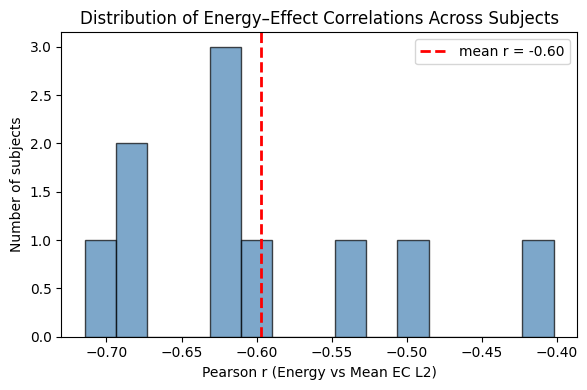

In [14]:
# =====================================================
# 📊 Histogram of correlation coefficients
# =====================================================
plt.figure(figsize=(6,4))
plt.hist(df_corr['r'], bins=15, color='steelblue', edgecolor='k', alpha=0.7)
plt.axvline(df_corr['r'].mean(), color='red', lw=2, linestyle='--', label=f"mean r = {df_corr['r'].mean():.2f}")
plt.xlabel("Pearson r (Energy vs Mean EC L2)")
plt.ylabel("Number of subjects")
plt.title("Distribution of Energy–Effect Correlations Across Subjects")
plt.legend()
plt.tight_layout()
plt.show()

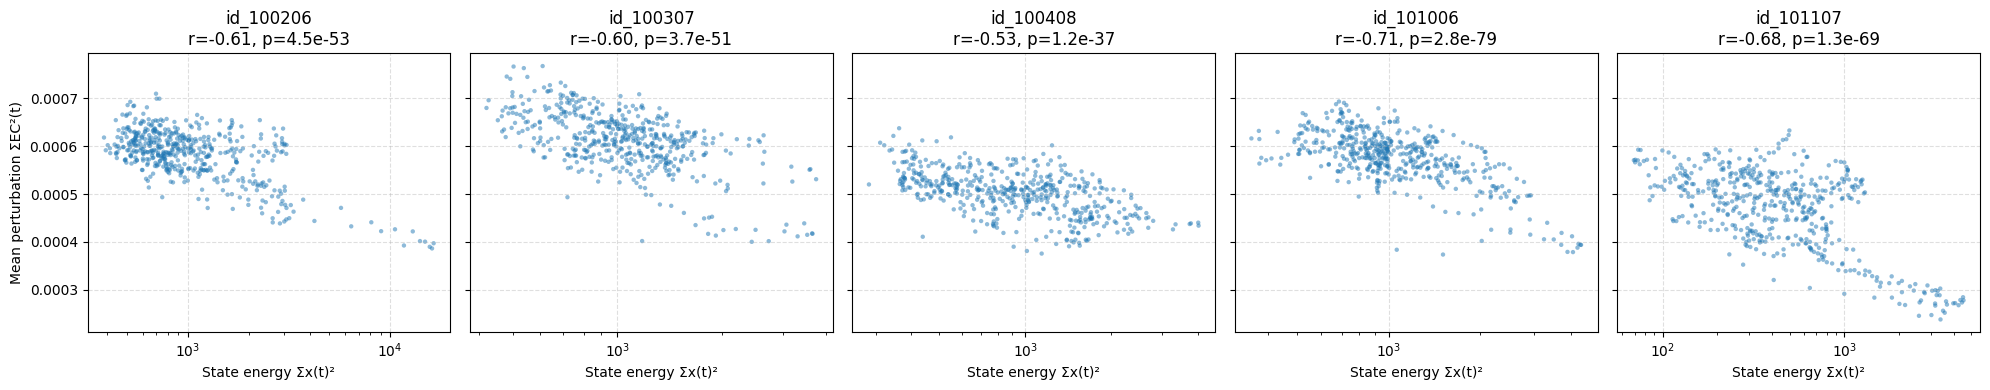

In [20]:
# =====================================================
# 📈 Scatter plots for selected subjects
# =====================================================
# Choose how many subjects to show (avoid too many subplots)
n_plot = min(5, len(scatter_data))  # plot up to 6 subjects
sel_subjects = list(scatter_data.keys())[:n_plot]

fig, axs = plt.subplots(1, n_plot, figsize=(4*n_plot, 4), sharey=True)
if n_plot == 1:
    axs = [axs]

for ax, sid in zip(axs, sel_subjects):
    E_t, EC_mean_t = scatter_data[sid]
    r = df_corr.loc[df_corr['subj'] == sid, 'r'].values[0]
    p = df_corr.loc[df_corr['subj'] == sid, 'p'].values[0]
    ax.scatter(E_t, EC_mean_t, s=10, alpha=0.5, edgecolors='none')
    ax.set_title(f"{sid}\nr={r:.2f}, p={p:.2g}")
    ax.set_xlabel("State energy Σx(t)²")
    ax.set_xscale('log')
    #ax.set_yscale('log')
    if ax == axs[0]:
        ax.set_ylabel("Mean perturbation ΣEC²(t)")
    ax.grid(ls='--', alpha=0.4)

plt.tight_layout()
plt.show()


# Network dependence of background dependence

### 1) Show that the magnitude of the effects depends on which region is being stimulated (responsiveness). Group by networks. Search correlations with receptor densities.
### 2) Show that the relation between pre-stimulus energy and post-stimulus effects (pre-to-post correlation) depends on which region is being stimulated. We hypothesize that effects of stimulating primary networks are more predictable from the pre-state, compared to stimulating associative networks.